In [1]:
from datasets import *

从 VisiumHD 生成 Visium

In [2]:
path = '/data/datasets/Visium_HD_Human_Tonsil_Fresh_Frozen/binned_outputs/square_002um'
imagefile = '/data/datasets/Visium_HD_Human_Tonsil_Fresh_Frozen/Visium_HD_Human_Tonsil_Fresh_Frozen_tissue_image.tif'
rawdata = VisiumHDData()
rawdata.load(path=path, source_image_path=imagefile)

In [3]:
visium_profile = VisiumProfile(slide_serial=4)

In [4]:
emulate_visium = rawdata.generate_Visium(visium_profile)

/home/yiriso/Research/Super-resolvedST/SuperResolvedST-Pipline/profiles.py:295: UserWarning: Spot (77, 1) cover rate: 59.32%, that 240 bins outside the grid.
  warnings.warn(f"Spot {profile.id2array(id)} cover rate: {covered_rate:0.2f}%, that {uncovered[id]:d} bins outside the grid.")
/home/yiriso/Research/Super-resolvedST/SuperResolvedST-Pipline/profiles.py:295: UserWarning: Spot (77, 3) cover rate: 59.32%, that 240 bins outside the grid.
  warnings.warn(f"Spot {profile.id2array(id)} cover rate: {covered_rate:0.2f}%, that {uncovered[id]:d} bins outside the grid.")
/home/yiriso/Research/Super-resolvedST/SuperResolvedST-Pipline/profiles.py:295: UserWarning: Spot (77, 5) cover rate: 59.32%, that 240 bins outside the grid.
  warnings.warn(f"Spot {profile.id2array(id)} cover rate: {covered_rate:0.2f}%, that {uncovered[id]:d} bins outside the grid.")
/home/yiriso/Research/Super-resolvedST/SuperResolvedST-Pipline/profiles.py:295: UserWarning: Spot (77, 7) cover rate: 59.32%, that 240 bins ou

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [10]:
emulate_visium.locDF[emulate_visium.locDF["in_tissue"]==1]

,barcode,in_tissue,array_row,array_col,pxl_row_in_fullres,pxl_col_in_fullres
0,ATACGAAACCCCGCGT-1,1,0,0,31602,24462
1,AAAGAGTAGATCGTAG-1,1,0,2,31601,24828
2,AACGTGACCCAAGTGT-1,1,0,4,31599,25193
3,GAATAATGATCAGGTG-1,1,0,6,31598,25558
4,GATTTGTCGGTTGTCC-1,1,0,8,31596,25924
...,...,...,...,...,...,...
4921,TGAGTATGATTTCGTG-1,1,76,114,7473,45183
4922,TCGTACCGTTAATAAT-1,1,76,116,7471,45548
4923,ATTAGTGGGGAGAAAT-1,1,76,118,7470,45914
4924,AGTGTAGTACTTAGAC-1,1,76,120,7468,46279


In [16]:
emulate_visium.adata.var_names_make_unique()
emulate_visium.select_HVG(n_top_genes=2000)

In [17]:
emulate_visium.adata

AnnData object with n_obs × n_vars = 4559 × 2000
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

In [20]:
save_path = Path('test/HD2Visium')
emulate_visium.save(save_path)

Start convert
Finish convert


In [22]:
emulate_visium.image.shape

(40732, 65199, 3)

In [4]:
import cv2
import imageio.v2 as ii
import matplotlib.pyplot as plt
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [32]:
shape = (2000,int(40732/65199*2000))
img_resized = cv2.resize(emulate_visium.image, shape, interpolation=cv2.INTER_AREA)

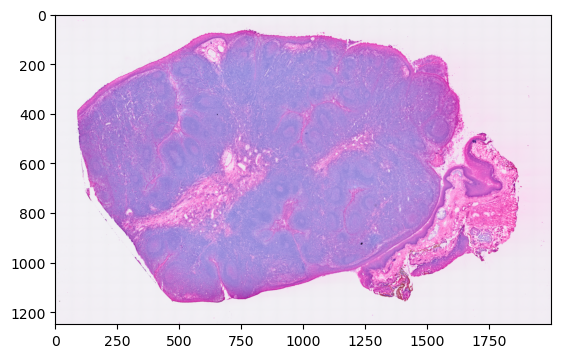

In [37]:
plt.imshow(img_resized)

In [60]:
def auto_mask(img : np.ndarray,
              CANNY_THRESH_1 = 100, CANNY_THRESH_2 = 200, apertureSize=5, L2gradient = True) -> np.ndarray:
    if len(img.shape)==3:
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    elif len(img.shape)==2:
        gray=(img*((1, 255)[np.max(img)<=1])).astype(np.uint8)
    else:
        print("Image format error!")
    edges = cv2.Canny(gray, CANNY_THRESH_1, CANNY_THRESH_2,apertureSize = apertureSize, L2gradient = L2gradient)
    edges = cv2.dilate(edges, None)
    edges = cv2.erode(edges, None)
    cnt_info = []
    cnts, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    for c in cnts:
        cnt_info.append((c,cv2.isContourConvex(c),cv2.contourArea(c),))
    cnt_info.sort(key=lambda c: c[2], reverse=True)
    cnt=cnt_info[0][0]
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.drawContours(mask, [cnt], contourIdx=-1, color=255, thickness=-1)
    return mask

In [61]:
mask = auto_mask(emulate_visium.image)
ii.imsave('test.png', mask)

In [5]:
mask = ii.imread('test/HD2Visium/mask.png')

In [6]:
mask.shape

(40732, 65199)